# Mushroom classification

## Setup

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

import matplotlib.pyplot as plt

2024-08-20 19:58:22.719455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 19:58:22.737251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 19:58:22.742376: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 19:58:22.756191: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.__version__)
# !pip freeze
# !pip install tensorflow==2.17.0
print(tf.config.experimental.list_physical_devices())

2.17.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1724183904.665433      15 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724183904.672244      15 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724183904.672435      15 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## Prepare the data

In [3]:
dataset_dir = '/data/dataset'

In [4]:
IMAGE_SIZE = 128
BATCH_SIZE = 128

In [5]:
train_dataset = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='training',
    seed=321,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_dataset = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='validation',
    seed=321,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
)


Found 27436 files belonging to 94 classes.
Using 21949 files for training.


I0000 00:00:1724183910.658167      15 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724183910.658380      15 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724183910.658530      15 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724183910.724084      15 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Found 27436 files belonging to 94 classes.
Using 5487 files for validation.


In [6]:
# Access class names
class_names = train_dataset.class_names
num_classes = len(class_names)

In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)

In [8]:
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

2024-08-20 19:58:37.504036: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-08-20 19:58:37.685106: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


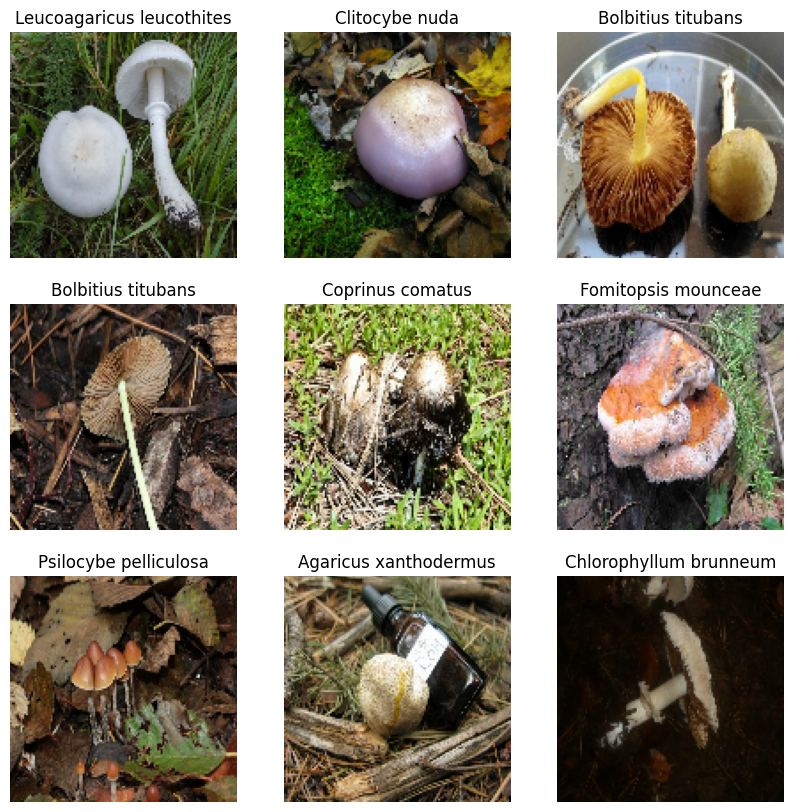

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Build the model

In [10]:
model = keras.Sequential(
    [
        keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        data_augmentation,
        
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        
        layers.Conv2D(96, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),

        layers.Conv2D(96, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.4),
        
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 96)       │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3456)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3456)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,769,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 94)             │        48,222 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,977,182 (7.54 MB)

 Trainable params: 1,976,606 (7.54 MB)

 Non-trainable params: 576 (2.25 KB)

## Train the model

In [11]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Retrieve the learning rate schedule
        lr_schedule = self.model.optimizer.learning_rate
        
        # If learning rate schedule is callable (e.g., ExponentialDecay)
        if callable(lr_schedule):
            # Get the learning rate value
            lr = lr_schedule(epoch).numpy()
        else:
            # For static learning rates
            lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)

        print(f'\nEpoch {epoch+1}: Learning rate is {lr:.6f}.')


callbacks = [
    LearningRateLogger(),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath='model.keras', save_best_only=True, save_freq='epoch')
]

In [12]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay


lr_schedule = ExponentialDecay(
    initial_learning_rate=0.5e-2,
    decay_steps=1000,
    decay_rate=0.8
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
epochs_count = 0

In [25]:
epochs_count -= 5

In [17]:
epochs = 10
epochs_count += epochs

history = model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_dataset,
    verbose=1,
)

print(f'Total epochs: {epochs_count}')


Epoch 1: Learning rate is 0.001581.
Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 87s 506ms/step - accuracy: 0.5476 - loss: 1.6366 - val_accuracy: 0.6165 - val_loss: 1.4478

Epoch 2: Learning rate is 0.001521.
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 88s 510ms/step - accuracy: 0.5547 - loss: 1.5841 - val_accuracy: 0.5823 - val_loss: 1.5704

Epoch 3: Learning rate is 0.001464.
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 88s 511ms/step - accuracy: 0.5575 - loss: 1.5631 - val_accuracy: 0.5418 - val_loss: 1.7022

Epoch 4: Learning rate is 0.001409.
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 88s 511ms/step - accuracy: 0.5636 - loss: 1.5268 - val_accuracy: 0.5859 - val_loss: 1.5800

Epoch 5: Learning rate is 0.001356.
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 88s 515ms/step - accuracy: 0.5781 - loss: 1.4775 - val_accuracy: 0.6483 - val_loss: 1.3291

Epoch 6: Learning rate is 0.001305.
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 88s 513ms/step - accuracy: 0.5940 - loss: 1.4247 - val_accuracy: 0.5814 - val_loss:

In [19]:
# Load the best model
model = tf.keras.models.load_model('model.keras')

## Evaluate the model

In [26]:
loss, accuracy = model.evaluate(val_dataset.shuffle(32))

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 2400, but received input with shape (None, 3456)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 128, 128, 3), dtype=float32)
  • training=False
  • mask=None

## Test the model

In [23]:
from tensorflow.keras.preprocessing import image


def preprocess_image(img_path, target_size=(110, 110)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0
    return img_array

In [20]:
test_model = tf.keras.models.load_model("/data/models/model_dabased_82a.keras")
test_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 110, 110, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 108, 108, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 54, 54, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 26, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 5, 96)       │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,229,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 94)             │        48,222 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,308,379 (16.44 MB)

 Trainable params: 1,435,934 (5.48 MB)

 Non-trainable params: 576 (2.25 KB)

 Optimizer params: 2,871,869 (10.96 MB)

In [21]:
import os


def test_the_model(model, class_names, test_dir="/data/test_data"):
    filenames = sorted(os.listdir(test_dir))
    for filename in filenames:
        img_path = os.path.join(test_dir, filename)
        preprocessed_img = preprocess_image(img_path)

        predictions = model.predict(preprocessed_img)
        predicted_class = np.argmax(predictions, axis=1)[0]
        probability = round(predictions[0, predicted_class] * 100, 2)
        print(f"Image ---- name: {filename}")
        print(f"Predicted class: {class_names[predicted_class]} ({probability}%)")

In [25]:
test_the_model(model=test_model, class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image ---- name: Boletus_rex-veris_1.jpg
Predicted class: Boletus rex-veris (99.96%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Image ---- name: Coprinellus-micaceus_20100424_0048.jpg
Predicted class: Psilocybe pelliculosa (92.66%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Image ---- name: Coprinellus_micaceus,_Mica_Inkcap.jpg
Predicted class: Psilocybe cubensis (74.75%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Image ---- name: Coprinellus_micaceus_Glimmer-Tintling.jpg
Predicted class: Coprinellus micaceus (99.75%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image ---- name: Coprinellus_micaceus_jk-132658.jpg
Predicted class: Coprinellus micaceus (91.16%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image ---- name: Ganoderma tsugae_19.jpg
Predicted class: Ganoderma tsugae (99.76%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image ---- name: Leucoagaricus-Americanus1.jpg
Predicted class: Leucoagaricus americanus (99.65%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image ---- name: Leu